mean red-chi squared =  2022987.9673296027
0.0002778269211951495
0.000365729344004058
775


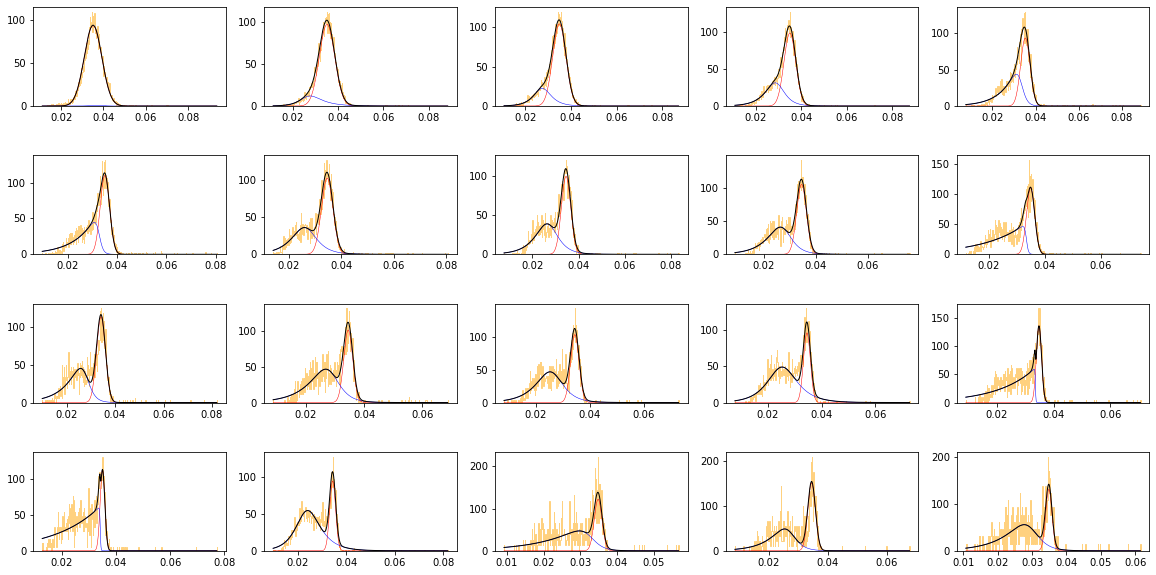

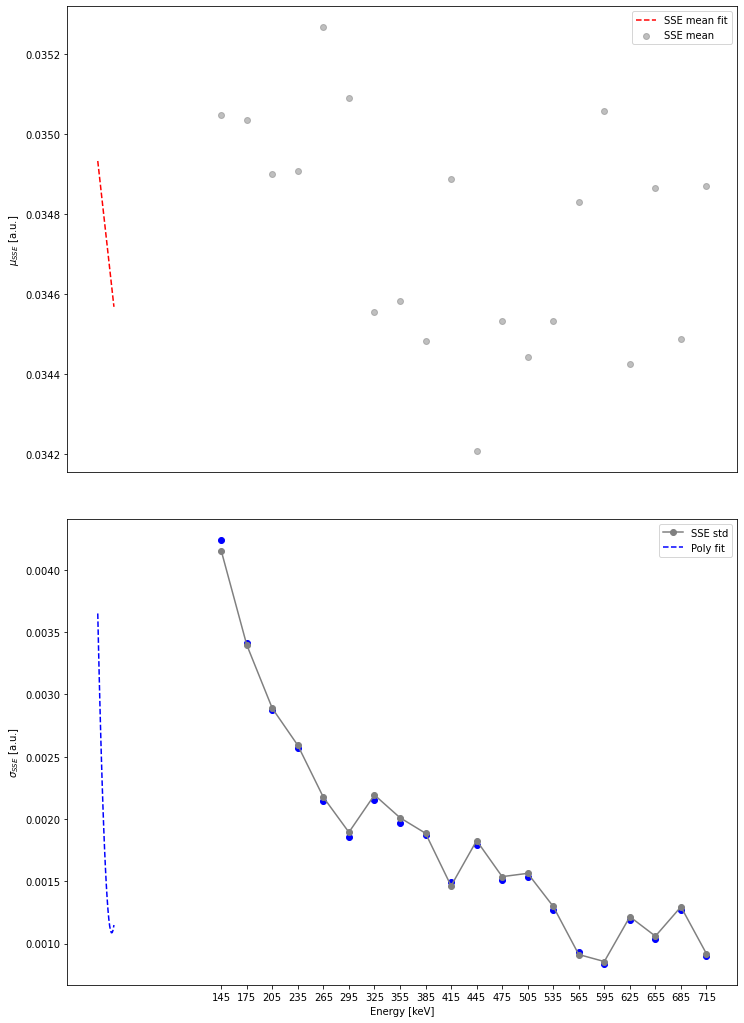

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0115_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.03444373720763273 # 0.034723684138888884 #0.03444373720763273
AoE = df[df.columns[1]]#/meanpeak


#-------------------------------------------------------
A , B, w = 145, 175, 30           #start - end - energy window  
n = 500
binw = 0.0005      #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(4,5, figsize=(20,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot = []
stds  =  []
stdtot = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(20):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = n, \
                       histtype=u'step', density=True, alpha=0.5, color='orange', \
                       label='%.f to %.f keV \nenteries = %.f\nbins no. =%.f' %(A, B, len(xdata),b))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    #xticks.append('%.f - %.f'%(A,B))
    xticks.append(A)

#-------------------------------------------------------

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.5 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    #paramslm2['t_m'].min  = 0.
    #paramslm2['t_m'].max  = 10  * paramslm2['t_m']
    #paramslm2['t_f'].min  = 0.2 * result3.params['e_f'].value
    #paramslm2['t_f'].max  = 5.0 * result3.params['e_f'].value
    #paramslm2['t_l'].min  = 0.5 * paramslm2['t_l']
    #paramslm2['t_l'].max  = 2.0 * paramslm2['t_l']
    #paramslm2['t_l'].vary = False
    paramslm2['t_d'].vary = False
    #paramslm2['t_t'].min  = 0.
    #paramslm2['t_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x, weights=weight)
    
    chi.append(resulttot.redchi)
    meanstot.append(resulttot.params['tot_mu'].value)
    stdtot.append(resulttot.params['tot_std'].value)
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
    axs[j].plot(x, SSE, color='r', lw=0.5, label='Gaussian')
    axs[j].plot(x, MSE, color='b', lw=0.5, label='Tail')
    axs[j].plot(x, resulttot.best_fit, color='k', lw=1, label='Fit')
    #axs[j].legend(loc=2, prop={'size': 7})
    #axs[j].set_xlim(0.5,1.5)
    #axs[j].set_xticks([0.1,1.0,1.5])
    A = A + w
    B = B + w

#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
#plt.savefig('IC_run0113 (205-%.f).pdf'%(B))

print("mean red-chi squared = ", mean(chi))

for i in range(len(chi)):
    if chi[i] > 200:
        chi[i] = 0

print(np.std(meanstot))
print(np.std(centroid_list))

fig, axs = plt.subplots(2,1, figsize=(12,18), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)

#axs[0].scatter(xticks, means, marker='o', color='r')
axs[0].scatter(xticks, meanstot, marker='o', alpha=0.5, color='gray', label='SSE mean') 
slope, intercept = np.poly1d(np.polyfit(np.arange(0,len(xticks)), meanstot, 1))
a = np.poly1d(np.polyfit(np.arange(0,len(xticks)), meanstot, 1))(np.unique(np.arange(0,len(xticks))))
axs[0].plot(np.unique(np.arange(0,len(xticks))), a, '--', color = 'r', label='SSE mean fit')

#axs[0].plot(xticks, centroid_list, marker='o',  color='g', label='centroid')
#axs[0].plot(np.unique(np.arange(0,len(xticks))), np.poly1d(np.polyfit(np.arange(0,len(xticks)), centroid_list, 1))\
#            (np.unique(np.arange(0,len(xticks)))), '--', color = 'g', label='centroid fit')

axs[1].scatter(xticks, stds, marker='o',  color='b')
axs[1].plot(xticks, stdtot, marker='o',  color='grey', label='SSE std')
axs[1].plot(np.unique(np.arange(0,len(xticks))), np.poly1d(np.polyfit(np.arange(0,len(xticks)), stdtot, 2))\
            (np.unique(np.arange(0,len(xticks)))), '--', color = 'b', label='Poly fit')

axs[0].set_xticks([])
axs[0].legend(prop={'size': 10})
axs[1].set_xticks([])
axs[1].legend(prop={'size': 10})
#axs[2].set_ylim(0, 10)
#axs[2].set_yticks(np.arange(0,10))
#axs[2].legend(prop={'size': 10})
#axs[2].grid(True)
#axs[0].axhline(1, linestyle=":", alpha=0.5, color='g')
#axs[0].set_ylim(0.95,1.15)
axs[0].set_ylabel('$\u03BC_{SSE}$ [a.u.]')
axs[1].set_ylabel('$\u03C3_{SSE}$ [a.u.]')
axs[1].set_xlabel('Energy [keV]')
#axs[0].set_ylim(0.985,1.04)
plt.xticks(xticks) #, rotation='vertical')


"""
fig = plt.figure(figsize=(9,9))

plt.plot(xticks, meanstot, marker='o',  color='r', label='SSE centroid')  
plt.plot(np.unique(np.arange(0,len(xticks))), np.poly1d(np.polyfit(np.arange(0,len(xticks)), meanstot, 1))\
            (np.unique(np.arange(0,len(xticks)))), ':', color = 'r', label='SSE fit')

#plt.plot(np.unique(np.arange(0,len(xticks))), np.poly1d(np.polyfit(np.arange(0,len(xticks)), centroid_list, 1))\
#            (np.unique(np.arange(0,len(xticks)))), '--', color = 'b', label='centroid fit')

plt.axhline(1, linestyle="--", color='violet')
plt.xticks([])
plt.ylim(0.97, 1.03)
plt.legend(prop={'size': 10})
plt.xticks(xticks, rotation='vertical')
#plt.savefig('stats %.f of bin width %.4f.pdf'%(np.mean(chi),binw))
"""
print(B)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model
#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("run0115_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
AoE = df[df.columns[1]]
#-------------------------------------------------------
A , B, w = 100, 130, 30  #start - end - energy window  
n = 500                          #bins
binw = 0.0005    #bin width
#------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#-------------------------------------------------------
fig, axs = plt.subplots(5,5, figsize=(30,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
#-------------------------------------------------------
chi2 = []
means2 = []
stds2  =  []
xticks2 = []
#------------------------------------------------------- data extraction
for j in range(25):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------

#------------------------------------------------------- bins and centroid
    y,x,_= axs[j].hist(xdata, bins = len(np.arange(min(xdata), max(xdata) + binw, binw)), histtype=u'step', density=True, alpha=0.7, color='orange', label='%.f to %.f keV \nenteries = %.f' %(A, B, len(xdata)))
    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
#-------------------------------------------------------

#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means2.append(result1.params['g_center'].value)
    stds2.append(result1.params['g_sigma'].value)
    xticks2.append('%.f - %.f'%(A,B))
#-------------------------------------------------------

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.5 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    #paramslm2['t_m'].min  = 0. #paramslm2['t_m'].max  = 10  * paramslm2['t_m'] 
    #paramslm2['t_f'].min  = 0.2 * result3.params['e_f'].value #paramslm2['t_f'].max  = 5.0 * result3.params['e_f'].value
    #paramslm2['t_l'].min  = 0.5 * paramslm2['t_l'] #paramslm2['t_l'].max  = 2.0 * paramslm2['t_l']
    #paramslm2['t_l'].vary = False
    paramslm2['t_d'].vary = False
    #paramslm2['t_t'].min  = 0.   #paramslm2['t_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value

    ss = np.linspace(min(x),max(x),1000)

    resulttot = modeltot.fit(y, paramstot, x=x)
    chi2.append(resulttot.redchi)
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
    axs[j].plot(x, SSE, color='r', lw=0.5, label='Gaussian')
    axs[j].plot(x, MSE, color='b', lw=0.5, label='Tail')
    axs[j].plot(x, resulttot.best_fit, color='k', lw=1, label='Fit')
    axs[j].legend(loc=2, prop={'size': 5})
    axs[j].set_xlim(0.01,0.05)
    axs[j].set_xticks([0.01,0.03,0.05])
    A = A + w
    B = B + w


fig.suptitle('Inverted Coax det=37, run-0115 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (bins=%.f).pdf'%(B,n))
plt.close()


<ipython-input-2-6b3649cd0e51>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-2-6b3649cd0e51>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-2-6b3649cd0e51>:23: RuntimeWarning: divide by zero encountered in true_divide
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


In [3]:
print(chi2)

[47.459973707954646, 6.497494815165141, 2.740598836449992, 3.1672555084771368, 2.5441607987709505, 3.8747929375935874, 8.417745231648173, 15.72089740586752, 9.030232562255385, 15.723875975416917, 14.226868740852028, 34.28328566944684, 28.44749341064645, 28.724042935445667, 31.22816544207455, 28.322477475020733, 44.47697317971772, 22.861158424924213, 127.92569335512697, 67.93850783575746, 34.41677095819941, 84.34372381948279, 69.53842849567019, 2.0627454888759536e+91, 42.69958740286513]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model
#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("run0115_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
AoE = df[df.columns[1]]
#-------------------------------------------------------
A , B, w = 100, 150, 50  #start - end - energy window  
n = 500                          #bins
binw = 0.0001    #bin width
#------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#-------------------------------------------------------
fig, axs = plt.subplots(5,5, figsize=(30,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
#-------------------------------------------------------
chi3 = []
means3 = []
stds3  =  []
xticks3 = []
#------------------------------------------------------- data extraction
for j in range(25):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------

#------------------------------------------------------- bins and centroid
    y,x,_= axs[j].hist(xdata, bins = len(np.arange(min(xdata), max(xdata) + binw, binw)), histtype=u'step', density=True, alpha=0.7, color='orange', label='%.f to %.f keV \nenteries = %.f' %(A, B, len(xdata)))
    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
#-------------------------------------------------------

#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means3.append(result1.params['g_center'].value)
    stds3.append(result1.params['g_sigma'].value)
    xticks3.append('%.f - %.f'%(A,B))
#-------------------------------------------------------

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.5 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    #paramslm2['t_m'].min  = 0. #paramslm2['t_m'].max  = 10  * paramslm2['t_m'] 
    #paramslm2['t_f'].min  = 0.2 * result3.params['e_f'].value #paramslm2['t_f'].max  = 5.0 * result3.params['e_f'].value
    #paramslm2['t_l'].min  = 0.5 * paramslm2['t_l'] #paramslm2['t_l'].max  = 2.0 * paramslm2['t_l']
    #paramslm2['t_l'].vary = False
    paramslm2['t_d'].vary = False
    #paramslm2['t_t'].min  = 0.   #paramslm2['t_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value

    ss = np.linspace(min(x),max(x),1000)

    resulttot = modeltot.fit(y, paramstot, x=x)
    chi3.append(resulttot.redchi)
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
    axs[j].plot(x, SSE, color='r', lw=0.5, label='Gaussian')
    axs[j].plot(x, MSE, color='b', lw=0.5, label='Tail')
    axs[j].plot(x, resulttot.best_fit, color='k', lw=1, label='Fit')
    axs[j].legend(loc=2, prop={'size': 5})
    axs[j].set_xlim(0.01,0.05)
    axs[j].set_xticks([0.01,0.03,0.05])
    A = A + w
    B = B + w


fig.suptitle('Inverted Coax det=37, run-0115 \n %.f keV window'%(w), fontsize=20)
plt.close()
#plt.savefig('from 100 to %.f keV (bins=%.f).pdf'%(B,n))


<ipython-input-4-01ba49324859>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-01ba49324859>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-01ba49324859>:23: RuntimeWarning: divide by zero encountered in true_divide
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-01ba49324859>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-01ba49324859>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


In [5]:
print(chi3)

[7.973021172585509, 8.463523132562912, 8.473080720023574, 13.429441038689665, 25.808097799548623, 27.11678313143169, 40.816652900090915, 51.58517678932447, 52.39115301579796, 71.53030814479276, 37.417859922877746, 190.2139386711703, 140.256867323352, 139.35243188095086, 127.4423636161497, 170.96956486878543, 119.55926130969955, 252.1711642323163, 736.0326856716496, 224.42476459258523, 380.61106259684345, 3.0431874608360926e+147, 347.6900257518447, 280.9001815347984, 441.55917302465053]


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model
#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("run0115_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
AoE = df[df.columns[1]]
#-------------------------------------------------------
A , B, w = 100, 150, 50  #start - end - energy window  
n = 500                          #bins
binw = 0.0005    #bin width
#------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#-------------------------------------------------------
fig, axs = plt.subplots(5,5, figsize=(30,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
#-------------------------------------------------------
chi4 = []
means4 = []
stds4  =  []
xticks4 = []
#------------------------------------------------------- data extraction
for j in range(25):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------

#------------------------------------------------------- bins and centroid
    y,x,_= axs[j].hist(xdata, bins = len(np.arange(min(xdata), max(xdata) + binw, binw)), histtype=u'step', density=True, alpha=0.7, color='orange', label='%.f to %.f keV \nenteries = %.f' %(A, B, len(xdata)))
    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
#-------------------------------------------------------

#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means4.append(result1.params['g_center'].value)
    stds4.append(result1.params['g_sigma'].value)
    xticks4.append('%.f - %.f'%(A,B))
#-------------------------------------------------------

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.5 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    #paramslm2['t_m'].min  = 0. #paramslm2['t_m'].max  = 10  * paramslm2['t_m'] 
    #paramslm2['t_f'].min  = 0.2 * result3.params['e_f'].value #paramslm2['t_f'].max  = 5.0 * result3.params['e_f'].value
    #paramslm2['t_l'].min  = 0.5 * paramslm2['t_l'] #paramslm2['t_l'].max  = 2.0 * paramslm2['t_l']
    #paramslm2['t_l'].vary = False
    paramslm2['t_d'].vary = False
    #paramslm2['t_t'].min  = 0.   #paramslm2['t_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value

    ss = np.linspace(min(x),max(x),1000)

    resulttot = modeltot.fit(y, paramstot, x=x)
    chi4.append(resulttot.redchi)
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
    axs[j].plot(x, SSE, color='r', lw=0.5, label='Gaussian')
    axs[j].plot(x, MSE, color='b', lw=0.5, label='Tail')
    axs[j].plot(x, resulttot.best_fit, color='k', lw=1, label='Fit')
    axs[j].legend(loc=2, prop={'size': 5})
    axs[j].set_xlim(0.01,0.05)
    axs[j].set_xticks([0.01,0.03,0.05])
    A = A + w
    B = B + w


fig.suptitle('Inverted Coax det=37, run-0115 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (bins=%.f).pdf'%(B,n))
plt.close()


<ipython-input-6-f9a2204208e0>:23: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


In [7]:
print(chi4)

[1.9845821346685835, 2.5838226488027383, 2.7884546383056894, 3.1848977643489693, 9.103889712762363, 8.519262180597726, 24.832442309043024, 23.72492248704871, 24.549429231595848, 28.790513455822055, 22.136394134286135, 41.43069498106556, 27.253756792086893, 51.40392915664361, 27.500041243584114, 45.84860230745868, 40.22702999607527, 43.594009818328516, 128.38261835077364, 39.24396875803805, 91.1223997681612, 44.945825816849094, 98.70131871418299, 70.39282495900983, 77.5775094064546]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

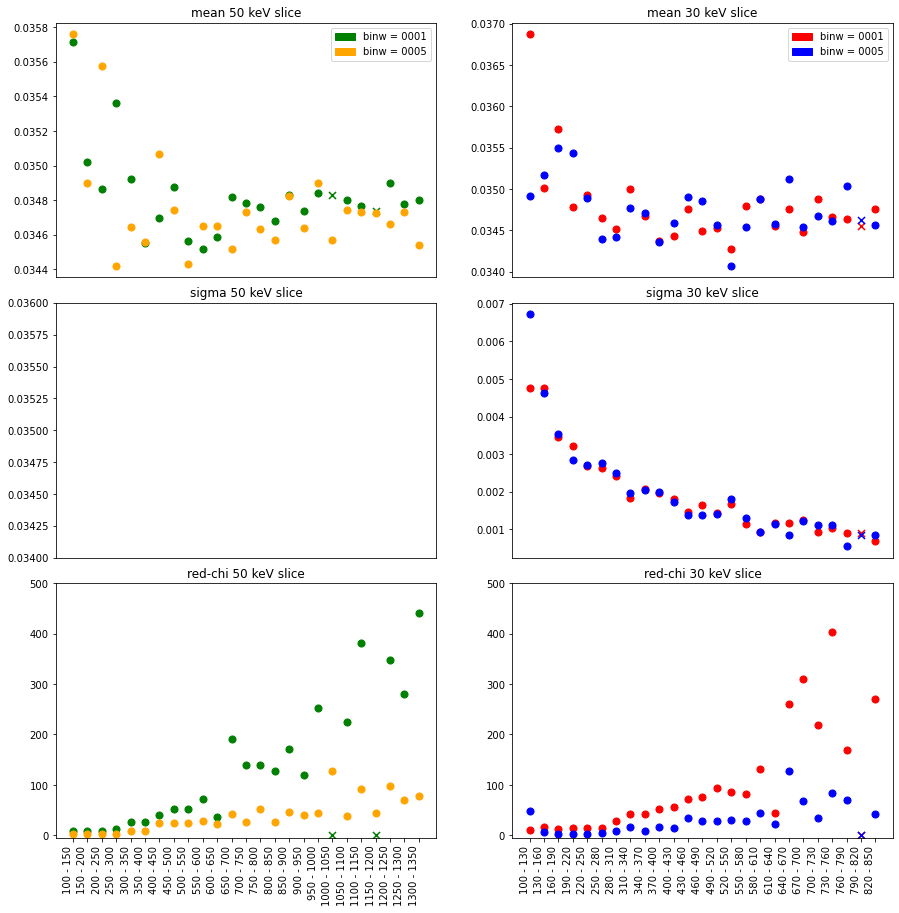

In [8]:
import matplotlib.patches as mpatches

for i in range(len(chi1)):
    if chi1[i] > 500:
        chi1[i] = 0
        
for i in range(len(chi2)):
    if chi2[i] > 500:
        chi2[i] = 0
        
for i in range(len(chi3)):
    if chi3[i] > 500:
        chi3[i] = 0
        
for i in range(len(chi4)):
    if chi4[i] > 500:
        chi4[i] = 0

fig, axs = plt.subplots(3,2, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)

for i in range(len(means1)):
    if chi1[i] == 0:
        axs[0][1].scatter(xticks1[i], means1[i], marker='x', s=50, color='r')
        axs[1][1].scatter(xticks1[i], stds1[i], marker='x', s=50, color='r')
        axs[2][1].scatter(xticks1[i], chi1[i], marker='x', s=50, color='r')    
    else:
        axs[0][1].scatter(xticks1[i], means1[i], marker='o', s=50, color='r')
        axs[1][1].scatter(xticks1[i], stds1[i], marker='o', s=50, color='r')
        axs[2][1].scatter(xticks1[i], chi1[i], marker='o', s=50, color='r') 
        
for i in range(len(means2)):
    if chi2[i] == 0:
        axs[0][1].scatter(xticks2[i], means2[i], marker='x', s=50, color='b')
        axs[1][1].scatter(xticks2[i], stds2[i], marker='x', s=50, color='b')
        axs[2][1].scatter(xticks2[i], chi2[i], marker='x', s=50, color='b')    
    else:
        axs[0][1].scatter(xticks2[i], means2[i], marker='o', s=50, color='b')
        axs[1][1].scatter(xticks2[i], stds2[i], marker='o', s=50, color='b')
        axs[2][1].scatter(xticks2[i], chi2[i], marker='o', s=50, color='b')

        
for i in range(len(means3)):
    if chi3[i] == 0:
        axs[0][0].scatter(xticks3[i], means3[i], marker='x', s=50, color='g')
        axs[1][0].scatter(xticks3[i], stds3[i], marker='x', s=50, color='g')
        axs[2][0].scatter(xticks3[i], chi3[i], marker='x', s=50, color='g')    
    else:
        axs[0][0].scatter(xticks3[i], means3[i], marker='o', s=50, color='g')
        axs[1][0].scatter(xticks3[i], stds3[i], marker='o', s=50, color='g')
        axs[2][0].scatter(xticks3[i], chi3[i], marker='o', s=50, color='g')
        
for i in range(len(means4)):
    if chi4[i] == 0:
        axs[0][0].scatter(xticks4[i], means4[i], marker='x', s=50, color='orange')
        axs[1][0].scatter(xticks4[i], stds4[i], marker='x', s=50, color='orange')
        axs[2][0].scatter(xticks4[i], chi4[i], marker='x', s=50, color='orange')    
    else:
        axs[0][0].scatter(xticks4[i], means4[i], marker='o', s=50, color='orange')
        axs[1][0].scatter(xticks4[i], stds4[i], marker='o', s=50, color='orange')
        axs[2][0].scatter(xticks4[i], chi4[i], marker='o', s=50, color='orange')

axs[0][0].set_xticks([])
axs[0][1].set_xticks([])
axs[0][0].set_title('mean 50 keV slice')
axs[0][1].set_title('mean 30 keV slice')

red = mpatches.Patch(color='red', label='binw = 0001')
blue = mpatches.Patch(color='blue', label='binw = 0005')
axs[0][1].legend(handles=[red, blue])

green = mpatches.Patch(color='green', label='binw = 0001')
orange = mpatches.Patch(color='orange', label='binw = 0005')
axs[0][0].legend(handles=[green, orange])


axs[1][0].set_xticks([])
axs[1][1].set_xticks([])
axs[1][0].set_title('sigma 50 keV slice')
axs[1][1].set_title('sigma 30 keV slice')

axs[2][0].set_ylim(-5,500)
axs[2][1].set_ylim(-5,500)
axs[2][0].set_title('red-chi 50 keV slice')
axs[2][1].set_title('red-chi 30 keV slice')


#axs[2][0].grid(True)
#axs[2][1].grid(True)

#axs[2][0].set_xticks(xticks, rotation='vertical')
#axs[2][1].set_xticks(xticks, rotation='vertical')
plt.setp(axs[2][0].get_xticklabels(), rotation='vertical', horizontalalignment='right')
plt.setp(axs[2][1].get_xticklabels(), rotation='vertical', horizontalalignment='right')
#plt.close()
#plt.savefig('Stats.pdf')

In [6]:
"""
for i in range(len(chi1)):
    if chi1[i] > 500:
        chi1[i] = 0

fig, axs = plt.subplots(3,1, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)

for i in range(len(means)):
    if chi[i] == 0:
        axs[0].scatter(xticks[i], means[i], marker='x', s=50, color='b')
        axs[1].scatter(xticks[i], stds[i], marker='x', s=50, color='b')
        axs[2].scatter(xticks[i], chi[i], marker='x', s=50, color='b')    
    else:
        axs[0].scatter(xticks[i], means[i], marker='o', s=50, color='b')
        axs[1].scatter(xticks[i], stds[i], marker='o', s=50, color='b')
        axs[2].scatter(xticks[i], chi[i], marker='o', s=50, color='b')    
    axs[0].set_xticks([])
    axs[0].set_title('mean')
    axs[1].set_xticks([])
    axs[1].set_title('sigma')
    axs[2].set_ylim(-5,500)
    axs[2].set_title('red-chi')
plt.legend(prop={'size': 15})
plt.xticks(xticks, rotation='vertical')
fig.suptitle('Inverted Coax det=37, run-0115 \n %.f keV window\nbin width = %.4f'%(w,binw), fontsize=20)
#plt.savefig('stats %.f of bin width %.4f.pdf'%(w,binw))

"""

"\nfor i in range(len(chi1)):\n    if chi1[i] > 500:\n        chi1[i] = 0\n\nfig, axs = plt.subplots(3,1, figsize=(15,15), facecolor='w', edgecolor='k')\nfig.subplots_adjust(hspace = .1, wspace=.2)\n\nfor i in range(len(means)):\n    if chi[i] == 0:\n        axs[0].scatter(xticks[i], means[i], marker='x', s=50, color='b')\n        axs[1].scatter(xticks[i], stds[i], marker='x', s=50, color='b')\n        axs[2].scatter(xticks[i], chi[i], marker='x', s=50, color='b')    \n    else:\n        axs[0].scatter(xticks[i], means[i], marker='o', s=50, color='b')\n        axs[1].scatter(xticks[i], stds[i], marker='o', s=50, color='b')\n        axs[2].scatter(xticks[i], chi[i], marker='o', s=50, color='b')    \n    axs[0].set_xticks([])\n    axs[0].set_title('mean')\n    axs[1].set_xticks([])\n    axs[1].set_title('sigma')\n    axs[2].set_ylim(-5,500)\n    axs[2].set_title('red-chi')\nplt.legend(prop={'size': 15})\nplt.xticks(xticks, rotation='vertical')\nfig.suptitle('Inverted Coax det=37, run-011

In [7]:
print(result1.fit_report())
resulttot.redchi

[[Model]]
    Model(gauss, prefix='g_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 16
    # variables        = 3
    chi-square         = 1745.03881
    reduced chi-square = 134.233755
    Akaike info crit   = 81.0710937
    Bayesian info crit = 83.3888599
[[Variables]]
    g_amp:     0.48291149 +/- 0.02417185 (5.01%) (init = 457)
    g_center:  0.03454198 +/- 3.6421e-05 (0.11%) (init = 0.03466113)
    g_sigma:   6.5331e-04 +/- 3.9724e-05 (6.08%) (init = 0.0003466113)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_amp, g_sigma)    =  0.839
    C(g_center, g_sigma) = -0.604
    C(g_amp, g_center)   = -0.591


77.5775094064546

In [19]:
print(chi4)
print(chi3)

[1.9845821346685835, 2.5838226488027383, 2.7884546383056894, 3.1848977643489693, 9.103889712762363, 8.519262180597726, 24.832442309043024, 23.72492248704871, 24.549429231595848, 28.790513455822055, 22.136394134286135, 41.43069498106556, 27.253756792086893, 51.40392915664361, 27.500041243584114, 45.84860230745868, 40.22702999607527, 43.594009818328516, 128.38261835077364, 39.24396875803805, 91.1223997681612, 44.945825816849094, 98.70131871418299, 70.39282495900983, 77.5775094064546]
[7.973021172585509, 8.463523132562912, 8.473080720023574, 13.429441038689665, 25.808097799548623, 27.11678313143169, 40.816652900090915, 51.58517678932447, 52.39115301579796, 71.53030814479276, 37.417859922877746, 190.2139386711703, 140.256867323352, 139.35243188095086, 127.4423636161497, 170.96956486878543, 119.55926130969955, 252.1711642323163, 0, 224.42476459258523, 380.61106259684345, 0, 347.6900257518447, 280.9001815347984, 441.55917302465053]
